In [107]:
# Import libraries
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display, Image
import time
%matplotlib inline

# Set common figure parameters
newparams = {'figure.figsize': (14, 7), 'axes.grid': False,
             'lines.markersize': 6, 'lines.linewidth': 2,
             'font.size': 15, 'mathtext.fontset': 'stix',
             'font.family': 'STIXGeneral'}
plt.rcParams.update(newparams)

In [108]:
def RHS(t, y):
    """Calculate the RHS of the EoM, as described above.
    Parameters:
        y: array. Vector of length 12 holding the current position and velocity of the three objects 
           in the following manner: y = [x1, y1, x2, y2, x3, y3, vx1, vy1, vx2, vy2, vx3, vy3].
    Returns:
        z: array. Vector of length 12 holding the derivative of the current position and velocity 
           (the velocity and acceleration) of the three object in the following manner:
           z = [vx1, vy1, vx2, vy2, vx3, vy3, ax1, ay1, ax2, ay2, ax3, ay3].
    """
    
    # Allocate a vector to hold the output values
    z = np.zeros(12)
    # Define initial velocities and distances between objects
    z[:6] = [y[6], y[7], y[8], y[9], y[10], y[11]]
    r21 = ((y[2] - y[0]) ** 2.0 + (y[3] - y[1]) ** 2.0) ** 0.5
    r31 = ((y[4] - y[0]) ** 2.0 + (y[5] - y[1]) ** 2.0) ** 0.5
    r32 = ((y[4] - y[2]) ** 2.0 + (y[5] - y[3]) ** 2.0) ** 0.5
    # Pairwise forces
    Fx21 = G * m2 * m1 * (y[2] - y[0]) / r21 ** 3.0
    Fy21 = G * m2 * m1 * (y[3] - y[1]) / r21 ** 3.0
    Fx31 = G * m3 * m1 * (y[4] - y[0]) / r31 ** 3.0
    Fy31 = G * m3 * m1 * (y[5] - y[1]) / r31 ** 3.0
    Fx32 = G * m3 * m2 * (y[4] - y[2]) / r32 ** 3.0
    Fy32 = G * m3 * m2 * (y[5] - y[3]) / r32 ** 3.0
    # Accelerations
    z[6] = (Fx21 + Fx31) / m1
    z[7] = (Fy21 + Fy31) / m1
    z[8] = (-Fx21 + Fx32) / m2
    z[9] = (-Fy21 + Fy32) / m2
    z[10] = (-Fx31 - Fx32) / m3
    z[11] = (-Fy31 - Fy32) / m3
    
    return z

In [109]:
def energy(z):
    """Calculate the mechanical energies of the three body system.
    Parameters:
        z: array. Vector of length 12 holding the current position and velocity of the three objects in the
           following manner: z = [x1, y1, x2, y2, x3, y3, vx1, vy1, vx2, vy2, vx3, vy3].
    Returns:
        U: float. The potential energies of the system.
        K: float. The kinetic energies of the system.
    """
    
    # Pairwise distance between objects
    r21 = ((z[2] - z[0]) ** 2.0 + (z[3] - z[1]) ** 2.0) ** 0.5
    r31 = ((z[4] - z[0]) ** 2.0 + (z[5] - z[1]) ** 2.0) ** 0.5
    r32 = ((z[4] - z[2]) ** 2.0 + (z[5] - z[3]) ** 2.0) ** 0.5
    
    # Calculate potential energies
    # First object is "free", second object is moved from infinity to a distance r21 from the first object.
    # Third object is affected gravitationally by both objects.
    U1 = 0
    U2 = -G * m1 * m2 / r21
    U3 = -G * m1 * m3 / r31 - G * m3 * m2 / r32
    U = U1 + U2 + U3
    
    # Calculate kinetic energies of the three objects
    K1 = 0.5 * m1 * (z[6] ** 2 + z[7] ** 2)
    K2 = 0.5 * m2 * (z[8] ** 2 + z[9] ** 2)
    K3 = 0.5 * m3 * (z[10] ** 2 + z[11] ** 2)
    K = K1 + K2 + K3
    
    return U, K

In [110]:
def angularMomentum(y):
    """Calculate absolute angular momentum of the three body system.
    Parameters:
        y:          array. Vector of length 12 holding the current position and velocity of the three objects
                    in the following manner: y = [x1, y1, x2, y2, x3, y3, vx1, vy1, vx2, vy2, vx3, vy3].
    Returns:
        L1, L2, L3: array. Total absolute angular momentum of the system.
    """
    
    L1 = m1 * (y[0] * y[7] - y[1] * y[6])
    L2 = m2 * (y[2] * y[9] - y[3] * y[8])
    L3 = m3 * (y[4] * y[11] - y[5] * y[10])
    
    return [L1, L2, L3]

In [111]:
def distanceToStars(y):
    """Calculate absolute angular momentum of the three body system.
    Parameters:
        y:          array. Vector of length 12 holding the current position and velocity of the three objects
                    in the following manner: y = [x1, y1, x2, y2, x3, y3, vx1, vy1, vx2, vy2, vx3, vy3].
    Returns:
        D1, D2: array. Distance of the first object(planet) to the other objects(stars).
    """
    d1 = ((y[0] - y[2]) ** 2 + (y[1] - y[3]) ** 2) ** 0.5
    d2 = ((y[0] - y[4]) ** 2 + (y[1] - y[5]) ** 2) ** 0.5
    
    return [d1, d2]

In [112]:
def ode45(f,t,y,h):
    """Calculate next step of an initial value problem (IVP) of an ODE with a RHS described
    by the RHS function with an order 4 approx. and an order 5 approx.
    Parameters:
        t: float. Current time.
        y: float. Current step (position).
        h: float. Step-length.
    Returns:
        q: float. Order 2 approx.
        w: float. Order 3 approx.
    """
    
    s1 = f(t, y)
    s2 = f(t + h / 4.0, y + h * s1 / 4.0)
    s3 = f(t + 3.0 * h / 8.0, y + 3.0 * h * s1 / 32.0 + 9.0 * h * s2 / 32.0)
    s4 = f(t + 12.0 * h / 13.0, y + 1932.0 * h * s1 / 2197.0 - 7200.0 * h * s2 / 2197.0 + 7296.0 * h * s3 / 2197.0)
    s5 = f(t + h, y + 439.0 * h * s1 / 216.0 - 8.0 * h * s2 + 3680.0 * h * s3 / 513.0 - 845.0 * h * s4 / 4104.0)
    s6 = f(t + h / 2.0, y - 8.0 * h * s1 / 27.0 + 2 * h * s2 - 3544.0 * h * s3 / 2565 + 1859.0 * h * s4 / 4104.0 - 11.0 * h * s5 / 40.0)
    w = y + h * (25.0 * s1 / 216.0 + 1408.0 * s3 / 2565.0 + 2197.0 * s4 / 4104.0 - s5 / 5.0)
    q = y + h * (16.0 * s1 / 135.0 + 6656.0 * s3 / 12825.0 + 28561.0 * s4 / 56430.0 - 9.0 * s5 / 50.0 + 2.0 * s6 / 55.0)
    
    return w, q

In [113]:
# Set gravitaional constant and masses.
# The gravitaional constant is set to 1 for simplicity.
G = 1.
m1 = 1.
m2 = 1.
m3 = 1.

# Period of calculations
T = 20
# Tolerance
TOL = 0.00001
# Maximum number of steps
maxi = 1000
# "Protector-constant" for small w
theta = 0.001

# Different initial conditions to try out, on the form
# y = [x1, y2, x2, y2, x3, y3, vx1, vy1, vx2, vy2, vx3, vy3]
# z0 = [2., 2., 0., 0., -2., -2., 0.2, -0.2, 0., 0., -0.2, 0.2]
# z0 = [-0.970, 0.243, 0.970, -0.243, 0., 0., -0.466, -0.433, -0.466, -0.433, 2*0.466, 2*0.433]
z0 = [2., 0., -2., 0., 0., 0., 0., -0.6, -0.6, 0., 0., 0.]
# z0 = [1., 0.000001, -1., 0., 0., 0., 0., -0.4, 0., 0.4, 0., 0.]

In [114]:
# First step and initial time
h = T / maxi
t = 0.

# Allocate matrices and fill with initial conditions
Z = np.zeros((12, maxi + 1))
Z[:, 0] = z0
E = np.zeros((maxi + 1, 2))
E[0, :] = energy(z0)
L = np.zeros((maxi + 1, 3))
L[0, :] = angularMomentum(z0)
D = np.zeros((maxi + 1, 2))
D[0, :] = distanceToStars(z0)

# Declare iteration integer
i = 0
e = 1.
# Perform ode45 calculations
tic = time.time()
while (t < T) & (i < maxi):
    w, q = ode45(RHS, t, Z[:, i], h)
    e = max(abs((w - q) / np.maximum(w, theta)))
    if e > TOL:
        h = 0.95 * (TOL * e) ** (1 / 5) * h 
        w, q = ode45(RHS, t, q, h)
        e = max(abs((w - q) / np.maximum(w, theta)))
        while e > TOL:
            h = h/2.
            w, q = ode45(RHS, t, q, h)
            e = max(abs((w - q) / np.maximum(w, theta)))
    if e < 0.1 * TOL:
        h = h * 2.
    Z[:, i + 1] = q
    E[i + 1, :] = energy(Z[:, i + 1])
    L[i + 1, :] = angularMomentum(Z[:, i + 1])
    D[i + 1, :] = distanceToStars(Z[:, i + 1])
    t += h
    i += 1

print("%.5f s, run time of adaptive RK45 method." % (time.time() - tic))
    
# Print number of steps used
if (i == maxi):
    print('%i, maximum number of steps reached by adaptive RK45 method.' % i)
else:
    print('%i, steps used by adaptive RK45 method.' % i)

0.42557 s, run time of adaptive RK45 method.
1000, maximum number of steps reached by adaptive RK45 method.


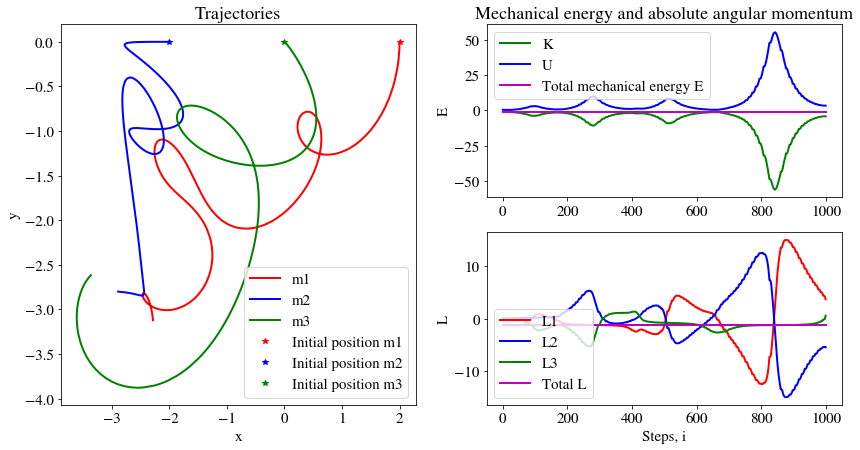

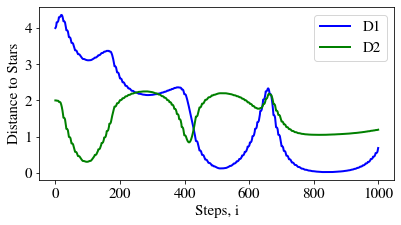

In [115]:
# Plot result
plt.figure()

# Position
plt.subplot(2, 2, (1, 3))
plt.plot(Z[0, 0:i], Z[1, 0:i], '-r', label='m1')
plt.plot(Z[2, 0:i], Z[3, 0:i], '-b', label='m2')
plt.plot(Z[4, 0:i], Z[5, 0:i], '-g', label='m3')
plt.plot(Z[0, 0], Z[1, 0], '*r', label='Initial position m1')
plt.plot(Z[2, 0], Z[3, 0], '*b', label='Initial position m2')
plt.plot(Z[4, 0], Z[5, 0], '*g', label='Initial position m3')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
plt.title('Trajectories')

# Mechanical energy
plt.subplot(2, 2, 2)
plt.plot(E[0:i, 0], 'g', label='K')
plt.plot(E[0:i, 1], 'b', label='U')
plt.plot(E[0:i, 0] + E[0:i ,1], 'm', label='Total mechanical energy E')
plt.ylabel('E')
plt.legend(loc='best')
plt.title('Mechanical energy and absolute angular momentum')

# Angular momentum
plt.subplot(2, 2, 4)
plt.plot(L[0:i, 0], 'r', label='L1')
plt.plot(L[0:i, 1], 'b', label='L2')
plt.plot(L[0:i, 2], 'g', label='L3')
plt.plot(L[0:i, 0] + L[0:i, 1] + L[0:i, 2], 'm', label='Total L')
plt.xlabel('Steps, i')
plt.ylabel('L')
plt.legend(loc=3)
plt.show()

# Distance to Stars
plt.subplot(2, 2, 2)
plt.plot(D[0:i, 0], 'b', label='D1')
plt.plot(D[0:i, 1], 'g', label='D2')
plt.xlabel('Steps, i')
plt.ylabel('Distance to Stars')
plt.legend(loc='best')
plt.show()